# Analyze A/B Test Results 



- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [110]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


In [111]:
df = pd.read_csv('ab_data.csv')

Use the cell below to find the number of rows in the dataset.

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The number of unique users in the dataset.

In [113]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [114]:
len(df[df['converted'] == 1])/len(df['converted'])

0.11965919355605512

The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [115]:
df_treatment = df[df['group'] == 'treatment']
len(df_treatment[df_treatment['landing_page'] == 'old_page'])


1965

Do any of the rows have missing values?

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Store your new dataframe in **df2**.

In [117]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query('(group == "control" and landing_page == "old_page") \
               or (group == "treatment" and landing_page == "new_page")')

In [118]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [119]:
df2['user_id'].nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [120]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Display the rows for the duplicate **user_id**? 

In [121]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [122]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(2893)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted



What is the probability of an individual converting regardless of the page they receive?<br><br>





In [123]:
#df2.head(2)
len(df2[df2['converted'] == 1])/len(df2['converted'])

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [124]:
df_control = df2[df2['group']=='control']
len(df_control[df_control['converted'] == 1])/len(df_control['converted'])

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [125]:
df_treatment = df2[df2['group']=='treatment']
len(df_treatment[df_treatment['converted'] == 1])/len(df_treatment['converted'])

0.11880806551510564

In [126]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = len(df_treatment[df_treatment['converted'] == 1])/len(df_treatment['converted'])\
- len(df_control[df_control['converted'] == 1])/len(df_control['converted'])

print(obs_diff)

-0.0015782389853555567


What is the probability that an individual received the new page?

In [127]:
len(df2[df2['landing_page'] == 'new_page']) / len(df2['landing_page'])

0.5000619442226688

Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

<b>1- by looking at the probabilty that individual recieved the new page, we found that its 50% so this means that people recive newpage = people recived old page
<br>
2- looking at both groups we found that the probabilty of people convert from control group is higher than treatment group with differance of 0.0016
<br>
3- the new treatment failed to get more conversions
 </b>

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page.

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

Null hypothese H0: $p_{new}$ - $p_{old}$ <= 0
<br>
Alternative hypothese H1: $p_{new}$ - $p_{old}$ > 0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 




What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [128]:
p_new = df2['converted'].mean()

print(p_new)

0.119597087245


What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [129]:
p_old = p_new
print(p_old)

0.119597087245


What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [130]:
n_new = len(df2[df2['group'] == 'treatment'])
print(n_new)

145310


What is $n_{old}$, the number of individuals in the control group?

In [131]:
n_old = len(df2[df2['group'] == 'control'])
print(n_old)

145274


Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [132]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], n_new, p=[p_new, (1-p_new)])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [133]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], n_old, p=[p_old, (1-p_old)])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [134]:
new_page_converted.mean() - old_page_converted.mean()

0.00032827082725440937

Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [135]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000) / n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_converted_simulation - old_converted_simulation

**Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

(array([   11.,    82.,   510.,  1486.,  2720.,  2852.,  1661.,   561.,
          100.,    17.]),
 array([ -4.59986249e-03,  -3.68857589e-03,  -2.77728929e-03,
         -1.86600268e-03,  -9.54716078e-04,  -4.34294746e-05,
          8.67857129e-04,   1.77914373e-03,   2.69043034e-03,
          3.60171694e-03,   4.51300354e-03]),
 <a list of 10 Patch objects>)

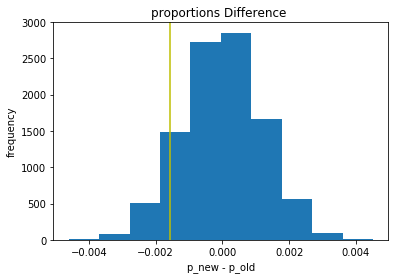

In [136]:
plt.axvline(obs_diff, c='y');
plt.title("proportions Difference ")
plt.xlabel("p_new - p_old")
plt.ylabel('frequency');
plt.hist(p_diffs)

What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [137]:
actual_diffs = (df2[df2['group'] == "treatment"]['converted'].mean()) - (df2[df2['group'] == "control"]['converted'].mean())
(p_diffs > actual_diffs).mean()


0.90559999999999996

Please explain in words what you have just computed above.
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

- the value called in scientific studies is p value 
- we can't reject null hypothesis since the (p_diffs > actual_diffs).mean() is = 0.7259 which is higher than the (0.05) type error rate
- therfore the new page doesn't have higher conversion rate than the old page.



**Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [138]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [139]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('landing_page == "old_page" and converted == 1 '))

# number of conversions with the new_page
convert_new = len(df2.query('landing_page == "new_page" and converted == 1 '))

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page == "old_page"'))

# number of individuals who received new_page
n_new = len(df2.query('landing_page == "new_page"'))

Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [140]:
import statsmodels.api as sm
#proportions_ztest(count_array, nobs_array, alternative='larger')
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in the above parts ?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

Z-score is another test of statistical significance that help to decide whether or not to reject the null hypothesis. Since the standard deviation here is small but our pvalue is quite large, it does not appear to be of interest.
The p-value which matches the earlier calculation, suggests that conversion from the old page are statistically better than the new.

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [141]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [142]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [143]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

Provide the summary of your model below, and use it as necessary to answer the following questions.

In [144]:
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Oct 2021   Pseudo R-squ.:               8.077e-06
Time:                        18:35:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


- The P-value associated with ab_page is 0.19 
- it differs because the test for part II was based on a hypothesis that one page versus another had a higher rate of converstion but this test is only concerned if there is a difference in the convestion rates of the pages.


Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is probably a good idea because the current hypotheses only have single factor for conversion which is treatment and control and it doesnt appear that they has much impact on whether a user converts or not thefore we should look on putting more factors.

**Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [145]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [146]:
# Join with the df2 dataframe
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [147]:
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [148]:
# Create the necessary dummy variables
df3[['US', 'CA', 'UK']] = pd.get_dummies(df3['country'])


In [149]:
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,CA,UK
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [150]:
df3['interaction'] = 1
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'CA']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Oct 2021   Pseudo R-squ.:               2.323e-05
Time:                        18:35:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0408      0.027      1.516      0.130      -0.012       0.093
CA             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [151]:
1 / np.exp(result.params)


intercept    7.614303
ab_page      1.015056
UK           0.960062
CA           0.950621
dtype: float64

- uk is 0.96 times more likely to convert compared to us
- ca is 0.95 times more likely to convert compared to us

Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [152]:
# Fit your model, and summarize the results
df3['CA_ab_page'] = df3['CA'] * df3['ab_page']
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']
logit_mod = sm.Logit(df3['converted'], df3[['intercept','CA', 'UK','ab_page' ,'CA_ab_page', 'UK_ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 15 Oct 2021   Pseudo R-squ.:               3.482e-05
Time:                        18:35:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
CA             0.0118      0.040      0.296      0.767      -0.066       0.090
UK             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
CA_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
UK_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [153]:
1 / np.exp(results.params)


intercept     7.418713
CA            0.988285
UK            0.982625
ab_page       1.069775
CA_ab_page    0.924703
UK_ab_page    0.954198
dtype: float64

<b>okey in conclusion with the last observation of uk_ab_page if a user from uk gets new page it would be about 1.02 times more likely to convert. which is small amount of statistical significance,  it does not hold much practical significance, so it is unlikely to be of any real use to us.

all in all, we dont have evidence to reject the null hypthesis based on any of our A/B testing. As a result, there is no reason to switch to the new page, when the old one performs just as well.</b>